## Imports

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform

from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, train_test_split, ValidationCurveDisplay, validation_curve
from sklearn.multioutput import MultiOutputRegressor

dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import tuning_search_top_configs
from training.metrics import mean_euclidean_error

%load_ext autoreload
%autoreload 2

2024-01-21 16:10:46.355101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# SVM
In this notebook we test a **SVC** and a **SVR** w.r.t. the tasks at hand, i.e. the three MONK's problems and the CUP dataset respectively.

## Settings

In [3]:
MODEL_NAME = 'SVM'
INTERNAL_TEST_SPLIT = 0.1 # internal test split percentage
RANDOM_STATE = 128 # reproducibility
N_SPLITS=5 # for cross-validation

## Path

In [4]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [4]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## GridSearch
Grid search is a simple hyper-parameter tuning techniques useful for finding the best configuration for a specific ML model. It involves:
- defining a grid of hparams values
- systematically test all possible combinations

In [5]:
# hparams grid for grid search
# hparams grid for grid search
clf_hparams_spaces = [
    {'kernel': ['rbf'], 'gamma': ['scale', 'auto'], 
                        'C': [0.1, 1, 10, 50, 100]
    },
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]
    },
    {'kernel': ['poly'], 'degree': [2,3,4],
                         'coef0': [0.0],
                         'gamma': ['scale', 'auto'],
                         'C': [0.1, 1, 10, 50, 100] 
    }
]

In [6]:
# perform grid search with KFold

grid_search_m1 = GridSearchCV(
    SVC(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m1.fit(x_dev_m1, y_dev_m1)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10, 50, 100],
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 50, 100], 'coef0': [0.0],
                          'degree': [2, 3, 4], 'gamma': ['scale', 'auto'],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=1)

In [7]:
best_configs_m1 = tuning_search_top_configs(grid_search_m1.cv_results_) # top k config

Model rank 1 - Config: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Mean score 1.0000 - Std score: 0.0000

Model rank 2 - Config: {'C': 50, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 1.0000 - Std score: 0.0000

Model rank 3 - Config: {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 1.0000 - Std score: 0.0000

Model rank 4 - Config: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 1.0000 - Std score: 0.0000

Model rank 5 - Config: {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
Mean score 1.0000 - Std score: 0.0000



## Training - Testing

In [8]:
# Create a SVC with the best hparams
#svc_m1 = SVC(**grid_search_m1.best_params_)

# Create and train the SVM
svc_m1 = SVC(C=10, degree=2, kernel='poly')
svc_m1.fit(x_dev_m1, y_dev_m1)

SVC(C=10, degree=2, kernel='poly')

In [9]:
print('-- DEVELOPMENT --')
acc_dev_m1 = accuracy_score(y_dev_m1, svc_m1.predict(x_dev_m1))
mse_dev_m1 = mean_squared_error(y_dev_m1, svc_m1.predict(x_dev_m1))
print(f'Loss (MSE): {mse_dev_m1:.4f} - Accuracy: {acc_dev_m1:.4f}')

-- DEVELOPMENT --
Loss (MSE): 0.0000 - Accuracy: 1.0000


In [10]:
print('-- TEST --')
acc_test_m1 = accuracy_score(y_test_m1, svc_m1.predict(x_test_m1))
mse_test_m1 = mean_squared_error(y_test_m1, svc_m1.predict(x_test_m1))
print(f'Loss (MSE): {mse_test_m1:.4f} - Accuracy: {acc_test_m1:.4f}')

-- TEST --
Loss (MSE): 0.0000 - Accuracy: 1.0000


## Store results

In [11]:
report_m1 = {
    'dev': {'mse': mse_dev_m1, 'accuracy': acc_dev_m1},
    'test': {'mse': mse_test_m1, 'accuracy': acc_test_m1}
}

store_monk_result(results_dir + '/MONK1/', svc_m1.get_params(), report_m1)

# MONK-2

In [12]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

## GridSearch

In [13]:
# perform grid search with KFold
grid_search_m2 = GridSearchCV(
    SVC(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m2.fit(x_dev_m2, y_dev_m2)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10, 50, 100],
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 50, 100], 'coef0': [0.0],
                          'degree': [2, 3, 4], 'gamma': ['scale', 'auto'],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=1)

In [14]:
best_configs_m2 = tuning_search_top_configs(grid_search_m2.cv_results_) # top k config

Model rank 1 - Config: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 0.9342 - Std score: 0.0723

Model rank 2 - Config: {'C': 50, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 0.9342 - Std score: 0.0723

Model rank 3 - Config: {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 0.7453 - Std score: 0.0791

Model rank 4 - Config: {'C': 50, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 0.7280 - Std score: 0.0933

Model rank 5 - Config: {'C': 100, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 0.7280 - Std score: 0.0933



## Training - Testing

In [15]:
# Create a SVC with the best hparams
#svc_m2 = SVC(**grid_search_m2.best_params_)

# Create and train the SVM
svc_m2 = SVC(C=50, degree=2, kernel='poly')
svc_m2.fit(x_dev_m2, y_dev_m2)

SVC(C=50, degree=2, kernel='poly')

In [16]:
print('-- DEVELOPMENT --')
acc_dev_m2 = accuracy_score(y_dev_m2, svc_m2.predict(x_dev_m2))
mse_dev_m2 = mean_squared_error(y_dev_m2, svc_m2.predict(x_dev_m2))
print(f'MSE: {mse_dev_m2:.4f} - Accuracy: {acc_dev_m2:.4f}')

-- DEVELOPMENT --
MSE: 0.0000 - Accuracy: 1.0000


In [17]:
print('-- TEST --')
acc_test_m2 = accuracy_score(y_test_m2, svc_m2.predict(x_test_m2))
mse_test_m2 = mean_squared_error(y_test_m2, svc_m2.predict(x_test_m2))
print(f'MSE: {mse_test_m2:.4f} - Accuracy: {acc_test_m2:.4f}')

-- TEST --
MSE: 0.0000 - Accuracy: 1.0000


## Store results

In [18]:
report_m2 = {
    'dev': {'mse': mse_dev_m2, 'accuracy': acc_dev_m2},
    'test': {'mse': mse_test_m2, 'accuracy': acc_test_m2}
}

store_monk_result(results_dir + '/MONK2/', svc_m2.get_params(), report_m2)

# MONK-3

In [19]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

## GridSearch

In [20]:
# perform grid search with KFold
grid_search_m3 = GridSearchCV(
    SVC(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m3.fit(x_dev_m3, y_dev_m3)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10, 50, 100],
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 50, 100], 'coef0': [0.0],
                          'degree': [2, 3, 4], 'gamma': ['scale', 'auto'],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=1)

In [21]:
best_configs_m3 = tuning_search_top_configs(grid_search_m3.cv_results_) # top k config

Model rank 1 - Config: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean score 0.9353 - Std score: 0.0477

Model rank 2 - Config: {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Mean score 0.9353 - Std score: 0.0477

Model rank 3 - Config: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mean score 0.9353 - Std score: 0.0477

Model rank 4 - Config: {'C': 1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Mean score 0.9353 - Std score: 0.0477

Model rank 5 - Config: {'C': 1000, 'kernel': 'linear'}
Mean score 0.9353 - Std score: 0.0477



## Training - Testing

In [22]:
# Create a SVC with the best hparams
#svc_m3 = SVC(**grid_search_m3.best_params_)

# Train the model
svc_m3 = SVC(C=10, degree=2, gamma='auto', kernel='poly')
svc_m3.fit(x_dev_m3, y_dev_m3)

SVC(C=10, degree=2, gamma='auto', kernel='poly')

In [23]:
print('-- DEVELOPMENT --')
acc_dev_m3 = accuracy_score(y_dev_m3, svc_m3.predict(x_dev_m3))
mse_dev_m3 = mean_squared_error(y_dev_m3, svc_m3.predict(x_dev_m3))
print(f'MSE: {mse_dev_m3:.4f} - Accuracy: {acc_dev_m3:.4f}')

-- DEVELOPMENT --
MSE: 0.0656 - Accuracy: 0.9344


In [24]:
print('-- TEST --')
acc_test_m3 = accuracy_score(y_test_m3, svc_m3.predict(x_test_m3))
mse_test_m3 = mean_squared_error(y_test_m3, svc_m3.predict(x_test_m3))
print(f'MSE: {mse_test_m3:.4f} - Accuracy: {acc_test_m3:.4f}')

-- TEST --
MSE: 0.0278 - Accuracy: 0.9722


## Storing results

In [25]:
report_m3 = {
    'dev': {'mse': mse_dev_m3, 'accuracy': acc_dev_m3},
    'test': {'mse': mse_test_m3, 'accuracy': acc_test_m3}
}

store_monk_result(results_dir + '/MONK3/', svc_m3.get_params(), report_m3)

# CUP

In [5]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

## Dev - Internal Test Split 
The development dataset is split between training and internal test ($90-10$).

In [6]:
# Split the internal test set
x_train_cup, x_internal_test_cup, y_train_cup, y_internal_test_cup = train_test_split(
    x_dev_cup, y_dev_cup, test_size=INTERNAL_TEST_SPLIT, random_state=128
)

## Hyper-paramater Tuning


Here, we define the grid search spaces for the SVR for the CUP dataset.

### Grid Search

In [7]:
grid_search_spaces_cup = [
    {'estimator__kernel': ['rbf'], 'estimator__gamma': ['scale', 'auto'], 
                                   'estimator__C': [0.1, 1, 10, 50, 100],
                                   'estimator__epsilon': [0.01, 0.1, 0.2, 0.5, 1]
    },
    {'estimator__kernel': ['linear'], 'estimator__C': [1, 10, 100, 1000],
                                      'estimator__epsilon': [0.01, 0.1, 0.2, 0.5, 1]
    },
    {'estimator__kernel': ['poly'], 'estimator__degree': [2,3,4],
                                    'estimator__coef0': [0.0],
                                    'estimator__gamma': ['scale', 'auto'],
                                    'estimator__C': [0.1, 1, 10, 50, 100],
                                    'estimator__epsilon': [0.01, 0.1, 0.2, 0.5, 1] 
    }
]

In [8]:
grid_search_cup = GridSearchCV(
    MultiOutputRegressor(SVR()), 
    grid_search_spaces_cup, 
    cv=KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE),
    scoring=make_scorer(mean_euclidean_error, greater_is_better = False),
    verbose=1
)

grid_search_cup.fit(x_train_cup, y_train_cup)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=128, shuffle=True),
             estimator=MultiOutputRegressor(estimator=SVR()),
             param_grid=[{'estimator__C': [0.1, 1, 10, 50, 100],
                          'estimator__epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                          'estimator__gamma': ['scale', 'auto'],
                          'estimator__kernel': ['rbf']},
                         {'estimator__C': [1, 10, 100, 1000],
                          'estimator__epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                          'estimator__kernel': ['linear']},
                         {'estimator__C': [0.1, 1, 10, 50, 100],
                          'estimator__coef0': [0.0],
                          'estimator__degree': [2, 3, 4],
                          'estimator__epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                          'estimator__gamma': ['scale', 'auto'],
                          'estimator__kernel': ['poly']}],
             scoring=make_scorer(mean_euclidean_error, greater_is_better=False),
             verbose=1)

In [9]:
best_configs_cup = tuning_search_top_configs(grid_search_cup.cv_results_) # top k config

Model rank 1 - Config: {'estimator__C': 100, 'estimator__epsilon': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Mean score -0.8121 - Std score: 0.0498

Model rank 2 - Config: {'estimator__C': 100, 'estimator__epsilon': 0.01, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Mean score -0.8130 - Std score: 0.0478

Model rank 3 - Config: {'estimator__C': 100, 'estimator__epsilon': 0.2, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Mean score -0.8212 - Std score: 0.0494

Model rank 4 - Config: {'estimator__C': 100, 'estimator__epsilon': 0.5, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Mean score -0.9507 - Std score: 0.0537

Model rank 5 - Config: {'estimator__C': 50, 'estimator__epsilon': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Mean score -0.9816 - Std score: 0.0591



### Random Search

In [10]:
best_params = grid_search_cup.best_params_
print(best_params)

{'estimator__C': 100, 'estimator__epsilon': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}


In [11]:
random_search_spaces_cup = {
    'estimator__C': uniform(max(0.1, best_params['estimator__C'] * 0.5), best_params['estimator__C'] * 2),
    'estimator__epsilon': uniform(max(0.01, best_params['estimator__epsilon'] * 0.8), best_params['estimator__epsilon'] * 1.3),
    'estimator__kernel': [best_params['estimator__kernel']],
    'estimator__gamma': [best_params['estimator__gamma']],
}

# uniform(loc, scale) => [loc, loc + scale] (if C=100 => [50, 250])
# If kernel = 'poly' add 'estimator__degree': [best_params['estimator__degree']] to the dict and as parameter in the validation_curve (next cell)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished


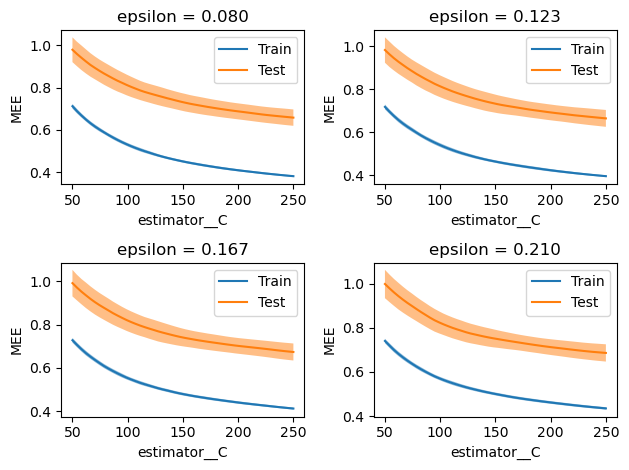

min_train_scores = [-0.3769, -0.391, -0.409, -0.4298]
min_test_scores = [-0.6169, -0.619, -0.6301, -0.6462]


In [26]:
# Validation curves using random search intervals
param_name = "estimator__C"
param_range = np.linspace(max(0.1, best_params['estimator__C'] * 0.5), best_params['estimator__C'] * 2 + max(0.1, best_params['estimator__C'] * 0.5))
epsilon_range = np.linspace(max(0.01, best_params['estimator__epsilon'] * 0.8), best_params['estimator__epsilon'] * 1.3 + max(0.01, best_params['estimator__epsilon'] * 0.8) , 4)
figure, axis = plt.subplots(2, 2)
min_train_scores=[]
min_test_scores=[]

for (epsilon, i, j) in zip(epsilon_range, [0,0,1,1], [0,1,0,1]):
    train_scores, test_scores = validation_curve(MultiOutputRegressor(SVR(kernel= best_params['estimator__kernel'], 
                                                     gamma = best_params['estimator__gamma'], 
                                                     epsilon=epsilon)), 
                                                 x_train_cup, 
                                                 y_train_cup, 
                                                 param_name=param_name, 
                                                 param_range=param_range,
                                                 cv=KFold(n_splits=5, shuffle=True, random_state=128),
                                                 scoring= make_scorer(mean_euclidean_error, greater_is_better = False),
                                                 verbose=1)
    
    min_train_scores.append(round(np.max(train_scores),4)) #score is negative
    min_test_scores.append(round(np.max(test_scores),4)) 
                                          
    display = ValidationCurveDisplay(param_name=param_name, 
                                     param_range=param_range,
                                     train_scores=train_scores, 
                                     test_scores=test_scores,
                                     score_name="MEE")
    display.plot(ax=axis[i,j], negate_score = True)
    axis[i,j].set_title('epsilon = %1.3f' %epsilon)

figure.tight_layout()
plt.show()
print(f"min_train_scores = {min_train_scores}")
print(f"min_test_scores = {min_test_scores}")

In [34]:
random_search_cup = RandomizedSearchCV(
    MultiOutputRegressor(SVR()), 
    random_search_spaces_cup, 
    n_iter=100, # number of configs sampled (do >100)
    cv=KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE),
    scoring=make_scorer(mean_euclidean_error, greater_is_better = False),
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_cup.fit(x_train_cup, y_train_cup)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=128, shuffle=True),
                   estimator=MultiOutputRegressor(estimator=SVR()), n_iter=100,
                   param_distributions={'estimator__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0c92ca7550>,
                                        'estimator__epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0c92c425d0>,
                                        'estimator__gamma': ['scale'],
                                        'estimator__kernel': ['rbf']},
                   random_state=128,
                   scoring=make_scorer(mean_euclidean_error, greater_is_better=False),
                   verbose=1)

In [35]:
best_score_grid = grid_search_cup.best_score_
best_score_random = random_search_cup.best_score_

# Check if best result is from GridSearc or RandomSearch
if best_score_random > best_score_grid:
    print("Best configuration from RandomizedSearch:\n")
    best_params = random_search_cup.best_params_
    print(best_params)
else:
    print("GridSearchCV resulted in the best configuration.")

Best configuration from RandomizedSearch:

{'estimator__C': 237.6392365545739, 'estimator__epsilon': 0.08621817770351486, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}


## Training - Testing

In [38]:
best_params = {k.replace('estimator__', ''): v for k, v in best_params.items()}

multi_svr = MultiOutputRegressor(SVR(**best_params))
multi_svr.fit(x_train_cup, y_train_cup)

MultiOutputRegressor(estimator=SVR(C=237.6392365545739,
                                   epsilon=0.08621817770351486))

In [39]:
print('-- TRAINING --')
mee_train_cup = mean_euclidean_error(y_train_cup, multi_svr.predict(x_train_cup))
mse_train_cup = mean_squared_error(y_train_cup, multi_svr.predict(x_train_cup))
print(f'Loss (MSE): {mse_train_cup:.4f} - MEE: {mee_train_cup:.4f}')

-- TRAINING --
Loss (MSE): 0.0829 - MEE: 0.3841


In [40]:
print('-- INTERNAL TEST --')
mee_internal_test_cup = mean_euclidean_error(y_internal_test_cup, multi_svr.predict(x_internal_test_cup))
mse_internal_test_cup = mean_squared_error(y_internal_test_cup, multi_svr.predict(x_internal_test_cup))
print(f'Loss (MSE): {mse_internal_test_cup:.4f} - MEE: {mee_internal_test_cup:.4f}')

-- INTERNAL TEST --
Loss (MSE): 0.3377 - MEE: 0.6878


In [41]:
# Blind test set predictions
blind_test_preds_cup = multi_svr.predict(x_test_cup)

## Store results

In [42]:
best_index = grid_search_cup.best_index_
mee_mean_score = -grid_search_cup.cv_results_['mean_test_score'][best_index]
mee_std_dev = std_validation_error = grid_search_cup.cv_results_['std_test_score'][best_index]

report_cup = {
    'train': {'mse': mse_train_cup, 'mee': mee_train_cup},
    'validation': {'mean_mee': mee_mean_score, 'std_dev_mee': mee_std_dev},
    'internal_test': {'mse': mse_internal_test_cup, 'mee': mee_internal_test_cup},
}

store_cup_result(results_dir + '/CUP/', best_params, report_cup, blind_test_preds_cup)